# Analyse CMIP5 and CMIP6 ODSL data and plot

In [107]:
import sys

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../Project_ProbSLR/CMIP_SeaLevel/code/')
import mod_loc as loc
import mod_postpro as pp

import regionmask
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from scipy.stats import linregress

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Read and prepare CMIP data

In [12]:
def read_zos_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    return tot_ds

In [13]:
# Check two path:
# ../Project_ProbSLR/CMIP_SeaLevel/outputs

# ../Project_ProbSLR/Data_Proj/Data_cmip5
# ../Project_ProbSLR/Data_Proj/Data_cmip6

In [16]:
cmip5_data_dir = '../Project_ProbSLR/CMIP_SeaLevel/outputs'
cmip6_data_dir = '../Project_ProbSLR/CMIP_SeaLevel/outputs'


In [314]:
cmip5_26_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp26')
cmip5_45_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp45')
cmip5_85_zos = read_zos_ds(cmip5_data_dir, 'cmip5', 'rcp85')

cmip6_126_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp126')
cmip6_245_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp245')
cmip6_585_zos = read_zos_ds(cmip6_data_dir, 'cmip6', 'ssp585')

In [322]:
# Select CMIP5 model intersection
cmip5_models = sorted(list(set(cmip5_26_zos.model.data) & 
                           set(cmip5_45_zos.model.data) & 
                           set(cmip5_85_zos.model.data)))

cmip5_26_zos = cmip5_26_zos.sel(model=cmip5_models)
cmip5_45_zos = cmip5_45_zos.sel(model=cmip5_models)
cmip5_85_zos = cmip5_85_zos.sel(model=cmip5_models)

print(f'Using {len(cmip5_models)} cmip5 models: \n {cmip5_models}')

Using 20 cmip5 models: 
 ['CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-R', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'NorESM1-ME', 'bcc-csm1-1', 'bcc-csm1-1-m']


In [321]:
# Select CMIP6 model intersection
cmip6_models = sorted(list(set(cmip6_126_zos.model.data) & 
                           set(cmip6_245_zos.model.data) & 
                           set(cmip6_585_zos.model.data)))

cmip6_126_zos = cmip6_126_zos.sel(model=cmip6_models)
cmip6_245_zos = cmip6_245_zos.sel(model=cmip6_models)
cmip6_585_zos = cmip6_585_zos.sel(model=cmip6_models)

print(f'Using {len(cmip6_models)} cmip6 models: \n {cmip6_models}')

Using 29 cmip6 models: 
 ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL']


### Select region of interest and tranform dataset to dataframe

In [23]:
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

ECE3_126_zos = cmip6_126_zos.CorrectedReggrided_zos.sel(model='EC-Earth3').isel(time=0)

# Define the mask and change its value from 0 to 1
mask_cmip = NLregion.mask_3D(ECE3_126_zos.lon, ECE3_126_zos.lat)



Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

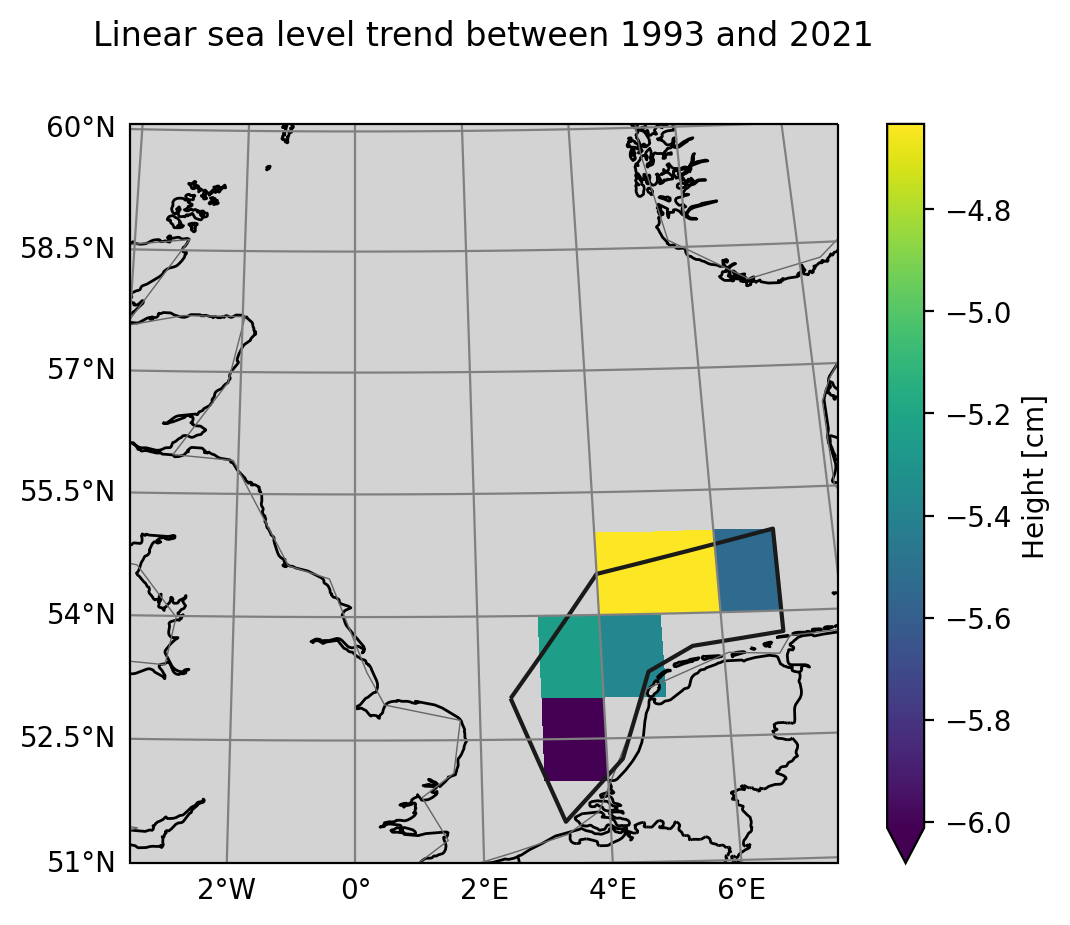

In [24]:
ECE3_126_zos_m = ECE3_126_zos.where(mask_cmip)

p = ECE3_126_zos_m.sel(lon=slice(lon_min-1,lon_max+1), 
                       lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'Height [cm]'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [54]:
def ds2df(cmip_ds, polygone_coord, start_year, end_year):
    '''Transform a dataset to a dataframe by averaging sea level over a region'''
    
    region = regionmask.Regions([polygone_coord], names=['Reg'], abbrevs=['Reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_cmip = region.mask_3D(cmip_ds.lon, cmip_ds.lat)
    
    #cmip_ds_m = cmip_ds.CorrectedReggrided_zos.where(mask_cmip)
    
    weights = np.cos(np.deg2rad(cmip_ds.lat))

    sel_da = cmip_ds.weighted(mask_cmip * weights).mean(dim=('lat', 'lon'))

    df = pd.DataFrame(dict(time=np.arange(start_year,end_year)+0.5))
    df = df.set_index('time')

    for mod in sel_da.model.values:
        df[mod] = sel_da.sel(model=mod).isel(region=0).drop_vars(
            ['model', 'region', 'abbrevs', 'names']).to_dataframe()
        
    return df

In [323]:
start_year = 1900 #1970 #2006
end_year = 2100

cmip5_26_df = ds2df(cmip5_26_zos, NL, start_year, end_year)
cmip5_45_df = ds2df(cmip5_45_zos, NL, start_year, end_year)
cmip5_85_df = ds2df(cmip5_85_zos, NL, start_year, end_year)

cmip6_126_df = ds2df(cmip6_126_zos, NL, start_year, end_year)
cmip6_245_df = ds2df(cmip6_245_zos, NL, start_year, end_year)
cmip6_585_df = ds2df(cmip6_585_zos, NL, start_year, end_year)

### Compute linear sea level trends

In [325]:
def compute_linregress_trend_error(df):
    ''' Compute the trend and error in the trend given an dataframe of ODSL time 
    series for each models'''
    
    df = df*10 # Convert height from cm to mm
    
    length = np.arange(15,51,5)
    end_year = np.arange(1960,2031,5)
    
    slope = np.zeros([len(df.columns), len(length), len(end_year)])
    stderr = np.zeros([len(df.columns), len(length), len(end_year)])
    
    for idx_l, l in enumerate(length):
        for idx_ey, ey in enumerate(end_year):
            for m in range(len(df.columns)):
                sel_df = df.loc[ey-l:ey,:].iloc[:,m]
                res = linregress(sel_df.index, sel_df)

                slope[m,idx_l,idx_ey] = res.slope
                stderr[m,idx_l,idx_ey] = res.stderr
    
    ds = xr.Dataset({'slope': (['model', 'length', 'end_year'], slope), 
                     'stderr': (['model', 'length', 'end_year'], stderr)},
                   coords={'model': ('model', df.columns),
                          'length': ('length', length),
                          'end_year': ('end_year', end_year)} )
        
    return ds
    

In [326]:
cmip6_ds = compute_linregress_trend_error(cmip6_245_df)

cmip5_ds = compute_linregress_trend_error(cmip5_45_df)

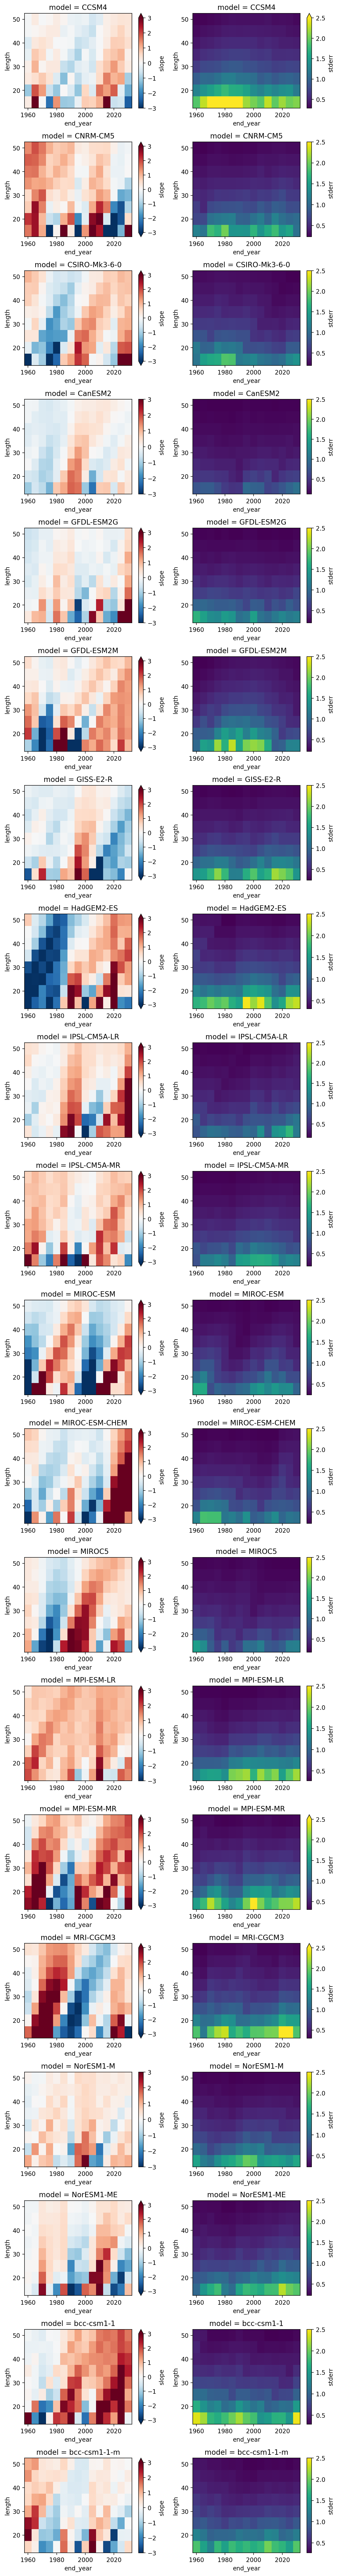

In [341]:
fig, axes = plt.subplots(nrows=len(cmip5_ds.model), ncols=2, figsize=(8, len(cmip5_ds.model)*3))

for idx, model in enumerate(cmip5_ds.model):
    cmip5_ds.slope.sel(model=model).plot(ax=axes[idx,0], vmin=-3, vmax=3, cmap='RdBu_r')
    cmip5_ds.stderr.sel(model=model).plot(ax=axes[idx,1], vmax=2.5)
    
plt.tight_layout()

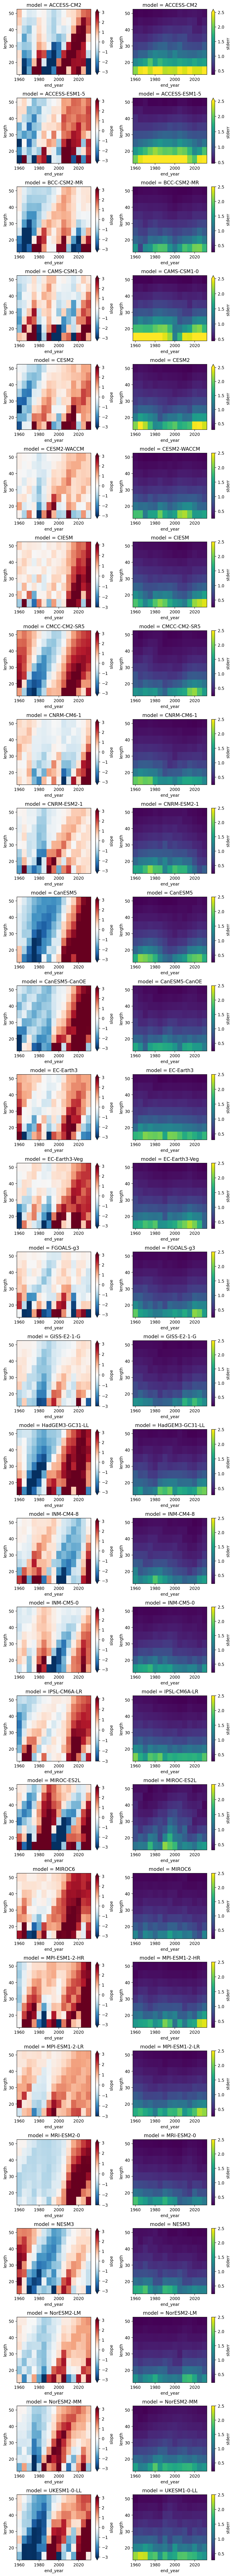

In [342]:
fig, axes = plt.subplots(nrows=len(cmip6_ds.model), ncols=2, figsize=(8, len(cmip6_ds.model)*3))

for idx, model in enumerate(cmip6_ds.model):
    cmip6_ds.slope.sel(model=model).plot(ax=axes[idx,0], vmin=-3, vmax=3, cmap='RdBu_r')
    cmip6_ds.stderr.sel(model=model).plot(ax=axes[idx,1], vmax=2.5)
    
plt.tight_layout()

### Compute values for the end of the century

In [345]:
for sd in [2080,2090]:
    cmip5_ds[f'val_26_{sd}_2100'] = (('model'), cmip5_26_df.loc[sd:2100].mean(axis=0))
    cmip5_ds[f'val_45_{sd}_2100'] = (('model'), cmip5_45_df.loc[sd:2100].mean(axis=0))
    cmip5_ds[f'val_85_{sd}_2100'] = (('model'), cmip5_85_df.loc[sd:2100].mean(axis=0))

In [343]:
for sd in [2080,2090]:
    cmip6_ds[f'val_126_{sd}_2100'] = (('model'), cmip6_126_df.loc[sd:2100].mean(axis=0))
    cmip6_ds[f'val_245_{sd}_2100'] = (('model'), cmip6_245_df.loc[sd:2100].mean(axis=0))
    cmip6_ds[f'val_585_{sd}_2100'] = (('model'), cmip6_585_df.loc[sd:2100].mean(axis=0))
    

## Compare correlation between current trend and future height

In [348]:
for sd in [2080,2090]:
    cmip5_ds[f'cor_26_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_26_{sd}_2100'], dim='model')
    cmip5_ds[f'cor_45_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_45_{sd}_2100'], dim='model')
    cmip5_ds[f'cor_85_{sd}_2100'] = xr.corr(cmip5_ds.slope, cmip5_ds[f'val_85_{sd}_2100'], dim='model')
    

In [336]:
for sd in [2080,2090]:
    cmip6_ds[f'cor_126_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_126_{sd}_2100'], dim='model')
    cmip6_ds[f'cor_245_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_245_{sd}_2100'], dim='model')
    cmip6_ds[f'cor_585_{sd}_2100'] = xr.corr(cmip6_ds.slope, cmip6_ds[f'val_585_{sd}_2100'], dim='model')
    

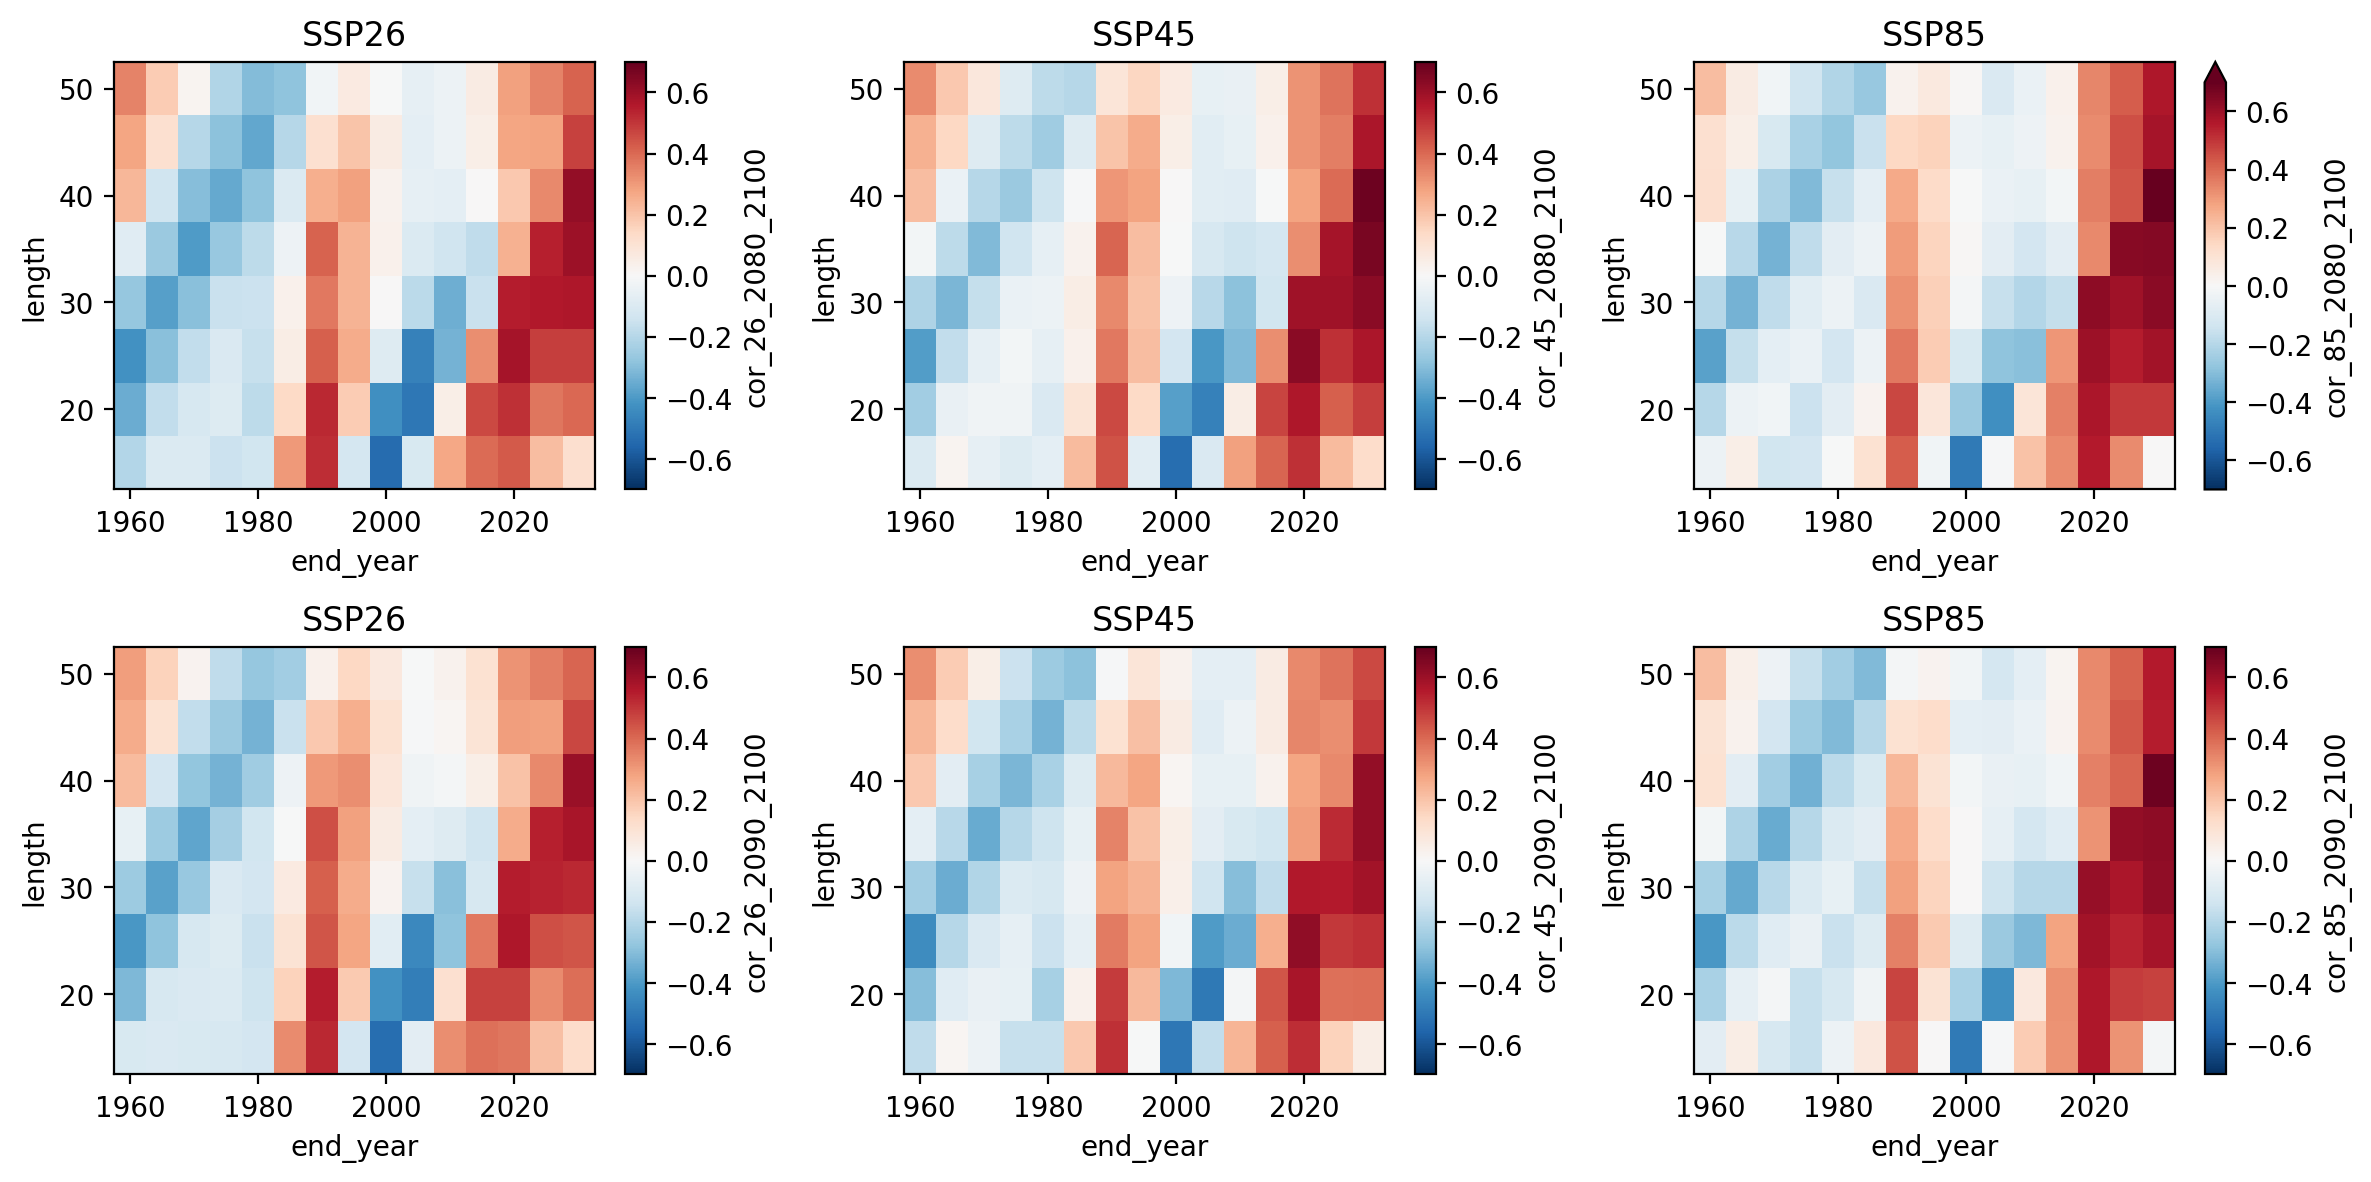

In [349]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([26, 45, 85]):
        cmip5_ds[f'cor_{scen}_{sd}_2100'].plot(ax=axes[idx,idy], vmin=-0.7, vmax=0.7, cmap='RdBu_r')
        axes[idx,idy].set_title(f'SSP{scen}')
    
plt.tight_layout()

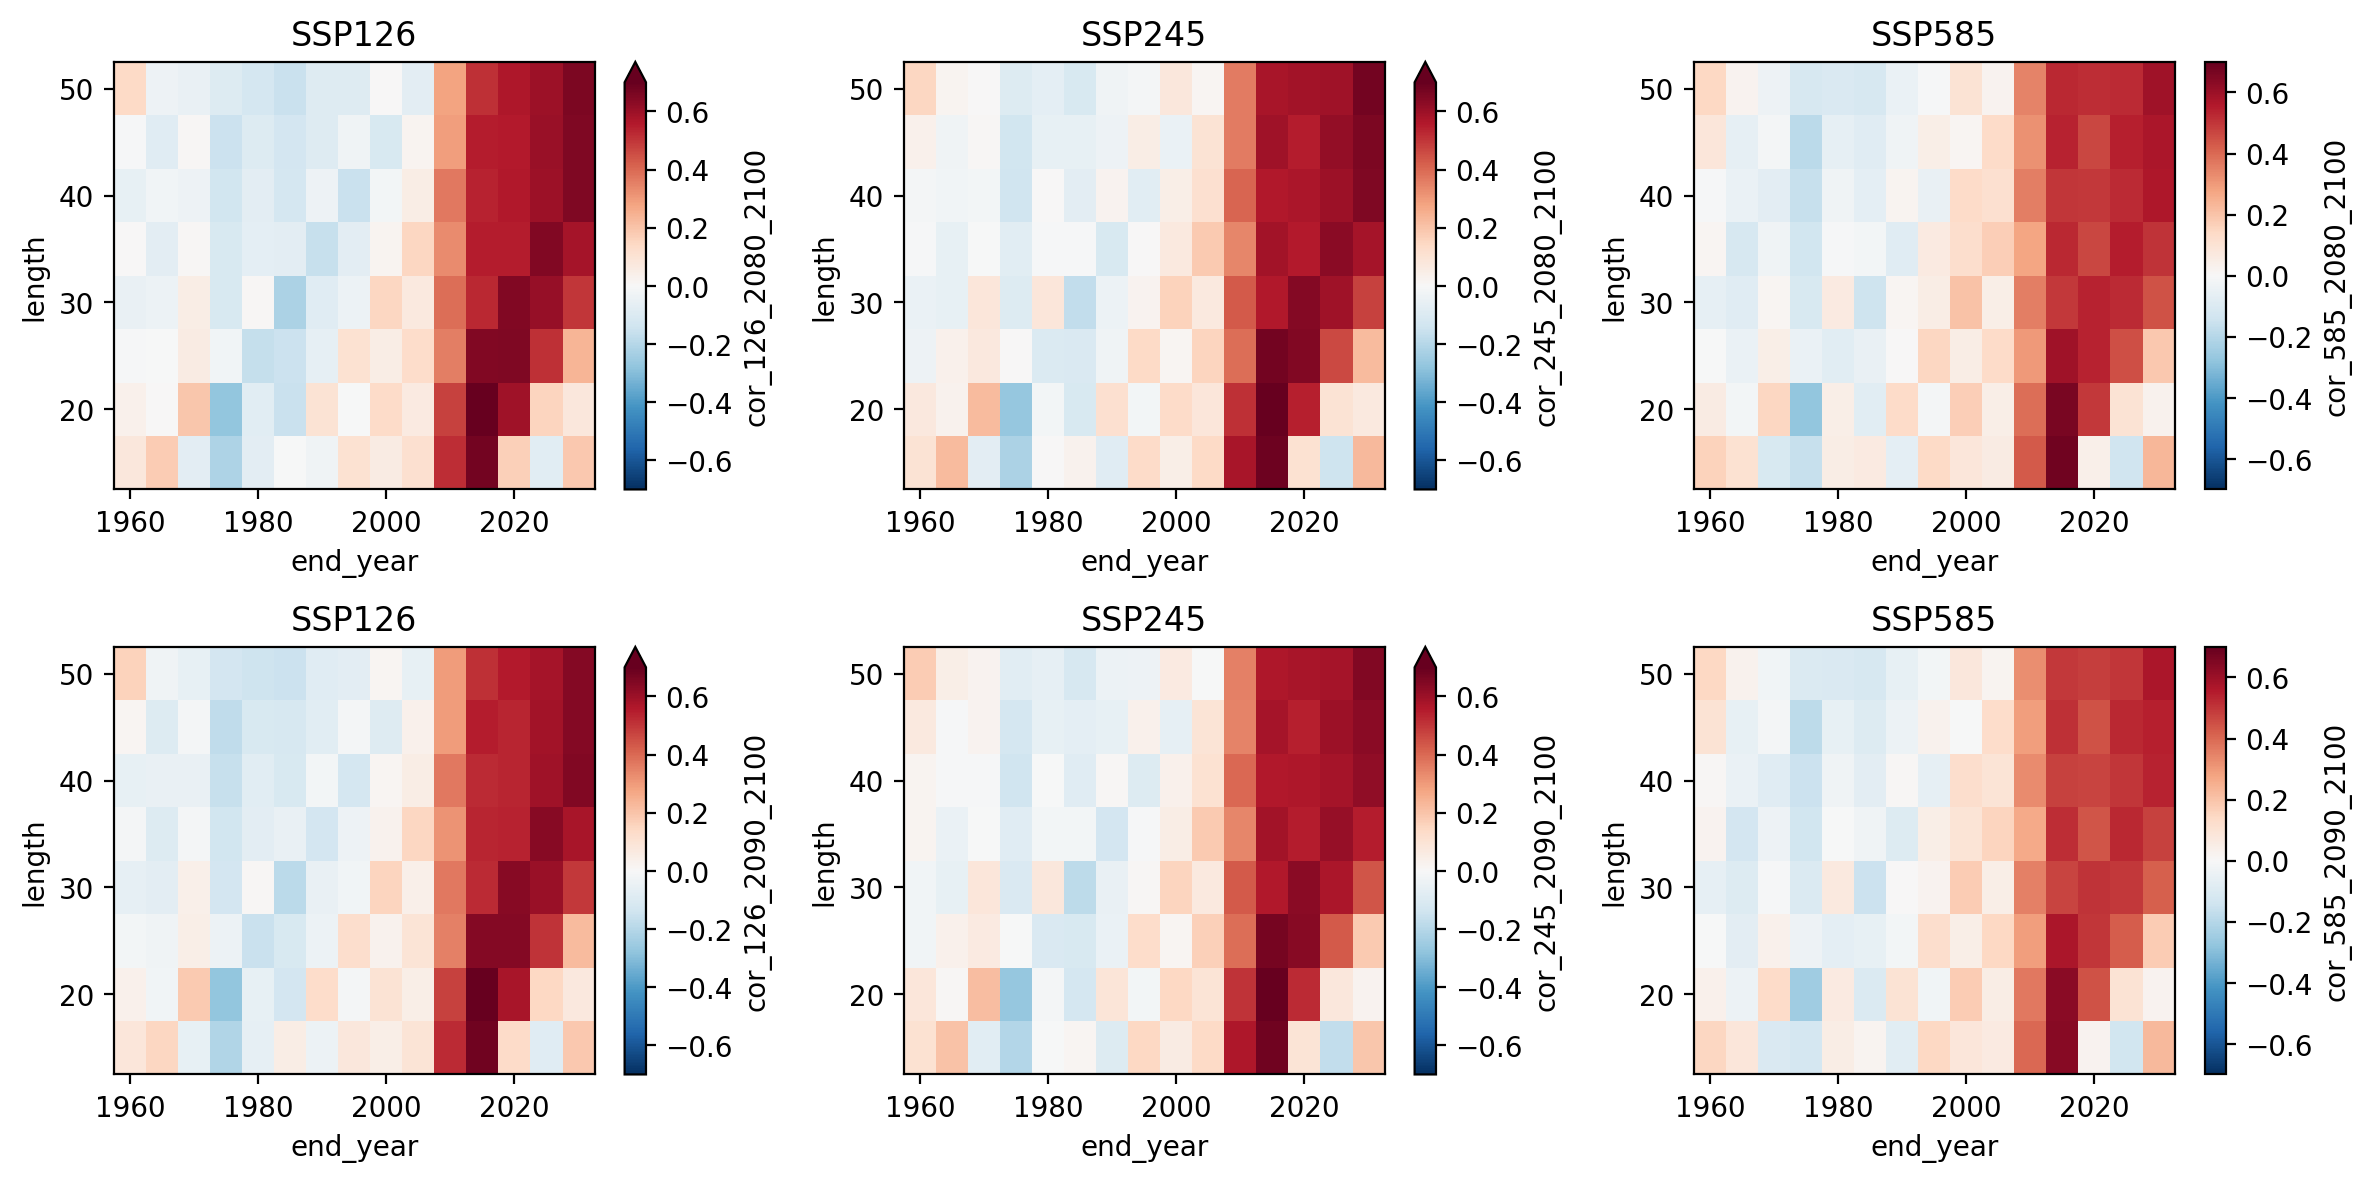

In [339]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for idx, sd in enumerate([2080,2090]):
    for idy, scen in enumerate([126, 245, 585]):
        cmip6_ds[f'cor_{scen}_{sd}_2100'].plot(ax=axes[idx,idy], vmin=-0.7, vmax=0.7, cmap='RdBu_r')
        axes[idx,idy].set_title(f'SSP{scen}')
    
plt.tight_layout()

Conclusion seem to be that for CMIP6 there is no need to use more than 25/30 years, even without wind correction. We have 29.

To do:
- Use the wind correction from Iris. Increased correlation?
- Correlation is already rather good in CMIP6. Compute it for CMIP5
- Import budget data
- Plot the comparison between budget estimates and model rates